In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D,Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from operator import itemgetter

In [2]:
batch_size = 400
epochs = 50

# Sensors for training
sensors = ['Hip', 'Wrist', 'Chest', 'Thigh']
segments = {
    "LES- socializing, communicating, leisure time not screen":"LES",
      "LES- screen based leisure time (TV, video game, computer)":"LES",
      "HA- animals and pets":"HA",
      "HA- housework":"HA",
      "HA- food prep and cleanup":"HA",
      "HA- household management/other household activities":"HA",
      "HA- interior maintenance, repair, & decoration":"HA",
      "HA- lawn, garden and houseplants":"HA",
      "HA- exterior maintenance, repair, & decoration":"HA",
      "CA- caring for and helping adults":"HA",
      "CA- caring for and helping children":"HA",
      "WRK- screen based - Education and Health Services":"WRK",
      "WRK- screen based - Office (business, professional services, finance, info)":"WRK",
      "WRK- general - Education and Health Services":"WRK",
      "WRK- general - Office (business, professional services, finance, info)":"WRK",
      "EDU- taking class, research, homework":"WRK",
      "PC- groom, health-related":"HA",
      "PC- other personal care":"HA",
      "EAT- eating and drinking, waiting":"HA",
      "PUR- purchasing goods and services":"HA",
      "ORG- organizational civic, volunteer, and religious activities":"COM",
      "EX- attending sport, recreational event, or performance":"COM",
      "EX- walking":"EX",
      "EX- jogging":"EX",
      "EX- baseball":"EX",
      "EX- other":"EX",
      "TRAV- walking":"COM",
      "TRAV- passenger bus or train":"COM",
      "TRAV- biking":"COM",
      "TRAV- driver (car/truck/motorcycle)":"COM",
      "OTHER- non codable":"OTHER",
      "None":"OTHER"
}

dummies = ['sit/lie', 'stand and move', 'walking', 'running',
               'bicycling']

Here is a list of fucntions in this ipynb:

`clean_data` cleans the data up and does some halving the parameter is present.

`aggregate` reshapes the data into a format that is usable with keras.

`run_kfold` runs the cross-validation we designed, fits and predicts the model, calcuates accuracy,
recall, precision, and f1-score, and makes confusion matrices.

`run_nn` is the main pipeline function that does all of these functions in the correct order.

`post_process` runs the post-processing algorithm we designed.

`print_confusion_matrix` does exactly that and makes it pretty.

`get_model_1layer_updated` is the convolutional neural network and its layers.

In [3]:
def clean_data(sensor, activity='updated_final_activity',halved=False):
    data = pd.read_csv('/mnt/storage/Datasets/final_data/'+sensor + ".csv", low_memory = False)
    # Take out unnamed columns
    data.drop([col for col in data.columns if "Unnamed" in col], axis=1, inplace = True)
    # Drop un-encoded data
    data = data[data[activity] != 'private/not coded'].reset_index()
    # add segment activity
    data["segment"] = data["primary_behavior"].map(segments)
    #print(data.shape)
    
    # enumerate segments
    # any time the primary behavior changes, we are in a new segment
    number = 0
    segment_group = []
    for index, row in data.iterrows():
        #print(index)
        if index == 0:
            segment_group.append(number)
            #segment_type.append(hip.loc[index,"segment"])
        else:
            current_segment = data.loc[index,"segment"]
            last_segment = data.loc[index - 1,"segment"]
            if last_segment != current_segment:
                # we are in a new segment
                number += 1
            segment_group.append(number)
    data["enum_segment"] = segment_group
    if not halved:
        return data
    else:
        data_halved = data[data.updated_final_activity != 'sit/lie']
        data2 = data[data.updated_final_activity == 'sit/lie'].sample(frac = 0.5)
        data_halved = data_halved.append(data2)
    return data

In [5]:
def aggregate(x_train,x_test,y_train,y_test,step=135):
    agged_x_train= []
    agged_y_train = []
    agged_x_test = []
    agged_y_test = []
    x_cols = pd.read_csv('../sasthana/CANOLLI/columns.csv')
    x_cols = x_cols['0'].to_list()
    #activities = data.updated_final_activity.unique()

    X_train = np.array(x_train.dropna())
    Y_train = np.array(y_train)
    X_test = np.array(x_test.dropna())
    Y_test = np.array(y_test)    
    Y_train = pd.get_dummies(Y_train).values
    Y_test = pd.get_dummies(Y_test).values
    
    X_train = np.concatenate((X_train,X_train[-2:,]), axis =0)
    Y_train = np.concatenate((Y_train,Y_train[-2:,]), axis =0)
    X_test = np.concatenate((X_test,X_test[-2:,]), axis =0)
    Y_test = np.concatenate((Y_test,Y_test[-2:,]), axis =0)
    
    i=0
    while i < len(X_train)-270:
        x_train = X_train[i:i+step,]
        y_train = Y_train[i:i+step,]
        agged_x_train.append(x_train)
        agged_y_train.append(y_train)
        i+= step
    agged_x_train = np.array(agged_x_train)
    agged_y_train = np.array(agged_y_train)
    
    i=0
    while i < len(X_test)-270:
        x_test = X_test[i:i+step,]
        y_test = Y_test[i:i+step,]
        agged_x_test.append(x_test)
        agged_y_test.append(y_test)
        i+= step
    agged_x_test = np.array(agged_x_test)
    agged_y_test = np.array(agged_y_test)
    return agged_x_train, agged_y_train, agged_x_test, agged_y_test

In [12]:
def run_kfold(X, Y, K, activity, class_labels,post=False):
    acc_sum = 0
    loss_sum = 0
    cnf_tables = []
    f1_rep = []
    prec_rep = []
    rec_rep = []
    cnf_total = np.zeros((5,5))
    i = 1
    model = None
    overall_categories = list(X["segment"].unique())
    for k in range(K):
        acts = 5
        # first, select test train split via stratified K-fold cross-validation
        # that is, within each category, do K-fold
        train = []
        test = []
        for cat in overall_categories:
            # extract all rows with this segement and get their enumerated segment
            subset = X[X["segment"] == cat]
            indexes = list(subset["enum_segment"].unique())

            # then stratified train test split
            train += [x for i,x in enumerate(indexes) if i % K != k]
            test += [x for i,x in enumerate(indexes) if i % K == k]   

        # Split data into train and test
        X_train, X_test = X[X["enum_segment"].isin(train)], X[X["enum_segment"].isin(test)]
        y_train, y_test = Y[X_train.index], Y[X_test.index]
            
        # drop segment related columns
        X_train.drop(columns = ["enum_segment","segment"], inplace = True)
        X_test.drop(columns = ["enum_segment","segment"], inplace = True)
        
        uniques = list(set(y_train.unique())-set(y_test.unique()))
        
        for act in uniques:
            train_indexes = y_train.index[y_train==act].tolist()
            X_train = X_train.drop(train_indexes)
            y_train = y_train.drop(train_indexes)
            acts = 4
        
        X_train, y_train, X_test, y_test = aggregate(X_train,X_test,y_train,y_test)
        
        # Reset model and get new one
        model = get_model_1layer_updated(acts=acts)
        
        model.fit(X_train,
          y_train,
          batch_size=50,
          epochs=30,
          validation_split=0.2,
          verbose=1)

        # Evaluate accuracy of model
        loss, acc = model.evaluate(X_test, y_test, steps = 1, verbose = 0)
        loss_r, acc_r = round(loss, 3), round(acc, 3)
        print("KFold: " + str(i) + ", loss: " + str(loss_r) +
         ", accuracy: " + str(acc_r))
        
        acc_sum = acc_sum + acc
        loss_sum = loss_sum + loss
        i += 1
        
        # Confusion matrix calculations
        
        # Get model predictions, save as list
#         pred = np.argmax(model.predict(X_test, verbose = 0),axis=1)
#         pred = np.argmax(pred,axis = 1)
#         pred = [class_labels[x] for x in pred]
#         if post == True:
#             pred = post_process(pred)
        
#         y_true = np.argmax(y_test,axis = 1)
#         y_true = np.argmax(y_true,axis = 1)
#         y_true = [class_labels[x] for x in np.array(y_true)]

        reshaped = y_test.shape[0]*y_test.shape[1]
        pred = model.predict(X_test, verbose = 1)
        pred = pred.reshape(reshaped,acts)
        y_pred = np.argmax(pred, axis=1)
        y_pred = [class_labels[x] for x in y_pred.tolist()]
        
        if post:
            y_pred = post_process(y_pred)
            
        reshaped = y_test.shape[0]*y_test.shape[1]
        y_true = np.argmax(y_test.reshape(reshaped,acts), axis = 1)
        y_true = [class_labels[x] for x in y_true.tolist()]

        # Make confusion matrix
        cnf_matrix = confusion_matrix(y_true, y_pred,
             labels=['sit/lie', 'stand and move', 'walking', 'running',
                'bicycling'])

        # Add confusion matrix for this fold to list
        cnf_tables.append(cnf_matrix)
        cnf_total += cnf_matrix
        
        class_report = precision_recall_fscore_support(y_true, y_pred, 
        labels = ['sit/lie', 'stand and move', 'walking', 'running','bicycling'])
        
        # get f1 for this fold 
        f1_rep.append(class_report[2:4])
        
        # get precision for this fold
        prec_rep.append(itemgetter(0,3)(class_report))
        
        # get recall for this fold
        rec_rep.append(itemgetter(1,3)(class_report))

    # Save last trained model to disk
    
    # Get average loss and accuracy for all kfolds
    loss_r, acc_r = round(loss_sum / K, 3), round(acc_sum / K, 3)
    
    actual_f1 = {'sit/lie':0, 'stand and move':0,'walking':0,'running':0,'bicycling':0}
    total_f1 = {'sit/lie':0,'stand and move':0, 'walking':0,'running':0,'bicycling':0}
    

    for f1 in f1_rep:
        actual_f1['sit/lie'] += f1[0][0] * f1[1][0]
        actual_f1['stand and move'] += f1[0][1] * f1[1][1]
        actual_f1["walking"] += f1[0][2] * f1[1][2]
        actual_f1["running"] += f1[0][3] * f1[1][3]
        actual_f1["bicycling"] += f1[0][4] * f1[1][4]
        total_f1['sit/lie'] += f1[1][0]
        total_f1['stand and move'] += f1[1][1]
        total_f1["walking"] += f1[1][2]
        total_f1["running"] += f1[1][3]
        total_f1["bicycling"] += f1[1][4]
        
    for k in list(actual_f1.keys()):
        print("F1 ",k,":",actual_f1[k]/total_f1[k])
    
    # print out precision stats
    actual_prec = {'sit/lie':0, 'stand and move':0,'walking':0,'running':0,'bicycling':0}
    total_prec = {'sit/lie':0, 'stand and move':0,'walking':0,'running':0,'bicycling':0}
    
    for prec in prec_rep:
        actual_prec['sit/lie'] += prec[0][0] * prec[1][0]
        actual_prec['stand and move'] += prec[0][1] * prec[1][1]
        actual_prec["walking"] += prec[0][2] * prec[1][2]
        actual_prec["running"] += prec[0][3] * prec[1][3]
        actual_prec["bicycling"] += prec[0][4] * prec[1][4]
        total_prec['sit/lie'] += prec[1][0]
        total_prec['stand and move'] += prec[1][1]
        total_prec["walking"] += prec[1][2]
        total_prec["running"] += prec[1][3]
        total_prec["bicycling"] += prec[1][4]
        
    for k in list(actual_prec.keys()):
        print("Precision ",k,":",actual_prec[k]/total_prec[k])
    
    # print out recall stats
    actual_re = {'sit/lie':0, 'stand and move':0,'walking':0,'running':0,'bicycling':0}
    total_re = {'sit/lie':0, 'stand and move':0,'walking':0,'running':0,'bicycling':0}
    
    for rec in rec_rep:
        actual_re['sit/lie'] += rec[0][0] * rec[1][0]
        actual_re['stand and move'] += rec[0][1] * rec[1][1]
        actual_re["walking"] += rec[0][2] * rec[1][2]
        actual_re["running"] += rec[0][3] * rec[1][3]
        actual_re["bicycling"] += rec[0][4] * rec[1][4]
        total_re['sit/lie'] += rec[1][0]
        total_re['stand and move'] += rec[1][1]
        total_re["walking"] += rec[1][2]
        total_re["running"] += rec[1][3]
        total_re["bicycling"] += rec[1][4]
        
    for k in list(actual_re.keys()):
        print("Recall ",k,":",actual_re[k]/total_re[k])
    
    return (loss_r, acc_r, cnf_tables)

In [7]:
def run_nn(sensor, activity='updated_final_activity',post=False,halved=False):
    data = clean_data(sensor,activity,halved)
    x_cols = data.columns[19:(82 + 19)]
    data = data.drop(data.index[data[activity].isna()==True].tolist())
    Y = data[activity]
    # Standardize x columns
    X = data[x_cols].apply(lambda x: (x - np.mean(x)) / np.std(x))
    X = X.fillna(X.mean()).values
    X = pd.DataFrame(X)
    # add segementation and enumeration
    X["segment"] = data.loc[:,"segment"]
    X["enum_segment"] = data.loc[:,"enum_segment"]
    
    # One hot vectorize categories
    
    #Y = pd.get_dummies(y).values
    dummy_labels = pd.get_dummies(Y).columns.tolist()
    
    # Run k-fold cross validation
    res = run_kfold(X, Y, 5, activity, dummy_labels,post)
    
    # Save confusion matrix visualizations
    #conf_mat(res, sensor, activity, dummy_labels)
    # Calculate precision/recall metrics, save results
    #prec_recall(res, sensor, activity, dummy_labels)
    return res

In [8]:
def post_process(preds):   
    """
    basic post processing...
    prediction: array of predicted values from the NN
    """
    #preds = prediction['predicted_values']
    preds_new = preds.copy()


    for i in range(2, len(preds)-2):
#         size = mode_size*2 +1
#         points = [None]* size
#         for j in range(size):
#             print(j)
#             print(points)
#             points[j] = preds.iloc[i - mode_size]
#             mode_size +=1
        points = [preds[i-2],preds[i-1], preds[i], preds[i+1], preds[i+2]]
        preds_new[i] = stats.mode(points)[0][0]

    #preds_new = pd.DataFrame(preds_new)
    #preds_new.columns = ['post_predictions']
    #final_preds = pd.concat([prediction,preds_new],axis =1)

    #errors_1 = final_preds['y_true'] == final_preds['predicted_values']
    #errors_2 = final_preds['y_true'] == final_preds['post_predictions']

    #print('predicted_value errors',np.sum(errors_1)/len(errors_1))

    #print('post_processed errors',np.sum(errors_2)/len(errors_2))
    
    #print('Accuracy improvement:', (np.sum(errors_2)/len(errors_2)-np.sum(errors_1)/len(errors_1)))
    return preds_new

In [9]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    #fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [21]:
def get_model_1layer_updated(acts=5):

    model = Sequential()
    model.add(Conv1D(filters=150, kernel_size=1, activation='relu', input_shape=(135,82)))
    model.add(Conv1D(filters=150, kernel_size=1, activation='relu'))
    model.add(Conv1D(filters=200, kernel_size=1, activation='relu'))
    model.add(Conv1D(filters=200, kernel_size=1, activation='relu'))
    model.add(Dense(100, activation='softmax'))
    model.add(Dense(acts,activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc'])
    print(model.summary())
    
    return model

In [42]:
loss_r,acc_r,con_matricies = run_nn('Hip',post=False,halved=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_185 (Conv1D)          (None, 135, 150)          12450     
_________________________________________________________________
conv1d_186 (Conv1D)          (None, 135, 150)          22650     
_________________________________________________________________
conv1d_187 (Conv1D)          (None, 135, 200)          30200     
_________________________________________________________________
conv1d_188 (Conv1D)          (None, 135, 200)          40200     
_________________________________________________________________
dense_104 (Dense)            (None, 135, 100)          20100     
_________________________________________________________________
dense_105 (Dense)            (None, 135, 4)            404       
Total params: 126,004
Trainable params: 126,004
Non-trainable params: 0
_______________________________________________

/home/auschwar/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/auschwar/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_189 (Conv1D)          (None, 135, 150)          12450     
_________________________________________________________________
conv1d_190 (Conv1D)          (None, 135, 150)          22650     
_________________________________________________________________
conv1d_191 (Conv1D)          (None, 135, 200)          30200     
_________________________________________________________________
conv1d_192 (Conv1D)          (None, 135, 200)          40200     
_________________________________________________________________
dense_106 (Dense)            (None, 135, 100)          20100     
_________________________________________________________________
dense_107 (Dense)            (None, 135, 4)            404       
Total params: 126,004
Trainable params: 126,004
Non-trainable params: 0
_______________________________________________

/home/auschwar/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/auschwar/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_193 (Conv1D)          (None, 135, 150)          12450     
_________________________________________________________________
conv1d_194 (Conv1D)          (None, 135, 150)          22650     
_________________________________________________________________
conv1d_195 (Conv1D)          (None, 135, 200)          30200     
_________________________________________________________________
conv1d_196 (Conv1D)          (None, 135, 200)          40200     
_________________________________________________________________
dense_108 (Dense)            (None, 135, 100)          20100     
_________________________________________________________________
dense_109 (Dense)            (None, 135, 5)            505       
Total params: 126,105
Trainable params: 126,105
Non-trainable params: 0
_______________________________________________

/home/auschwar/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_197 (Conv1D)          (None, 135, 150)          12450     
_________________________________________________________________
conv1d_198 (Conv1D)          (None, 135, 150)          22650     
_________________________________________________________________
conv1d_199 (Conv1D)          (None, 135, 200)          30200     
_________________________________________________________________
conv1d_200 (Conv1D)          (None, 135, 200)          40200     
_________________________________________________________________
dense_110 (Dense)            (None, 135, 100)          20100     
_________________________________________________________________
dense_111 (Dense)            (None, 135, 4)            404       
Total params: 126,004
Trainable params: 126,004
Non-trainable params: 0
_______________________________________________

/home/auschwar/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/auschwar/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_201 (Conv1D)          (None, 135, 150)          12450     
_________________________________________________________________
conv1d_202 (Conv1D)          (None, 135, 150)          22650     
_________________________________________________________________
conv1d_203 (Conv1D)          (None, 135, 200)          30200     
_________________________________________________________________
conv1d_204 (Conv1D)          (None, 135, 200)          40200     
_________________________________________________________________
dense_112 (Dense)            (None, 135, 100)          20100     
_________________________________________________________________
dense_113 (Dense)            (None, 135, 4)            404       
Total params: 126,004
Trainable params: 126,004
Non-trainable params: 0
_______________________________________________

/home/auschwar/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/auschwar/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


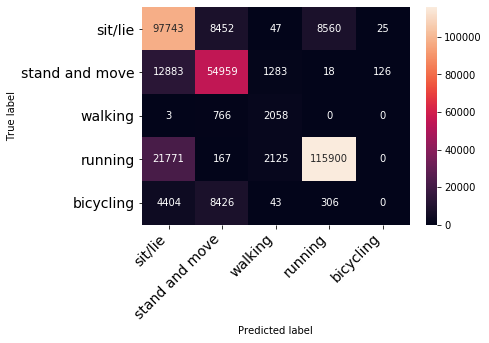

In [43]:
print_confusion_matrix(sum(con_matricies),['sit/lie', 'stand and move', 'walking', 'running','bicycling'])